# **2D Medical Image Segmentation with U-Net**


# **1. Introduction:**

In this project, we aim to develop an automated method for segmenting the hippocampus subfields in brain images using the Task4 dataset. Our focus is on leveraging the U-Net architecture, a well-regarded model in medical image segmentation. We will experiment with various configurations and data preprocessing techniques, including 2D modeling and transfer learning with pretrained models. The goal is to create a robust model that accurately identifies hippocampus subfields, contributing to advancements in medical imaging and enhancing the understanding and treatment of neurological disorders.

The project will explore various enhancements and configurations of U-Net, including:
*   Environment Setup and Library Imports
*   Data Loading
*   Data Visualization
*   Data Preprocessing: Several preprocessing techniques were applied, such as padding and normalization, to prepare the data for optimal training results.
*   2D U-Net Model for Segmentation: A 2D U-Net model was constructed to be trained on images.
*   Model Training
*   Prediction: The trained model was used to make predictions on new data, assessing its segmentation accuracy.


##**2. Environment Setup and Library Imports**

In [ ]:
# Importing functions for loading and processing images
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# ImageDataGenerator for real-time data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# os module for interacting with the operating system, like reading file paths
import os
# Numpy for numerical operations on arrays
import numpy as np
# sklearn's train_test_split for splitting data into training and validation sets
from sklearn.model_selection import train_test_split
# Importing necessary layers for building the 2D U-Net architecture
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
# Model class from Keras to construct the neural network model
from tensorflow.keras.models import Model
# Adam optimizer for training the model
from tensorflow.keras.optimizers import Adam
# to_categorical for one-hot encoding of labels
from tensorflow.keras.utils import to_categorical
# train_test_split (repeated import) from sklearn for splitting dataset into training and testing sets
from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras.applications import EfficientNetB0
# For mounting Google Colab drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**2. Data Loading**

This function will now load each image and its corresponding mask from the specified folders, convert them to numpy arrays, and append them to separate lists. The function returns these lists as numpy arrays. The images are loaded in RGB color mode and normalized by dividing by 255.0, while the masks are loaded in grayscale mode.

In [ ]:
def load_images_and_masks(main_image_folder, main_mask_folder):
    images, masks = [], []

    for subdir in os.listdir(main_image_folder):
        image_folder = os.path.join(main_image_folder, subdir)
        mask_folder = os.path.join(main_mask_folder, subdir)

        if not os.path.isdir(image_folder) or not os.path.isdir(mask_folder):
            continue

        for img_name in os.listdir(image_folder):
            # Load and convert image to NumPy array
            img_path = os.path.join(image_folder, img_name)
            img = load_img(img_path, color_mode='rgb')
            img_array = img_to_array(img) / 255.0
            images.append(img_array)

            # Load and convert mask to NumPy array
            mask_path = os.path.join(mask_folder, img_name)
            mask = load_img(mask_path, color_mode='grayscale')
            mask_array = img_to_array(mask)
            masks.append(mask_array)

    return np.array(images), np.array(masks)

images, masks = load_images_and_masks('/content/drive/MyDrive/Hippocampus/Hippocampus_png', '/content/drive/MyDrive/Hippocampus/Hippocampus_label')

<ipython-input-2-c5d509134413>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(images), np.array(masks)


#**3. Visualize the Dataset**

This function selects a number of image-mask pairs randomly from the provided arrays and visualizes them. The images are displayed in their original color, while the masks are displayed in grayscale. You can adjust the num_pairs parameter to display more or fewer pairs.

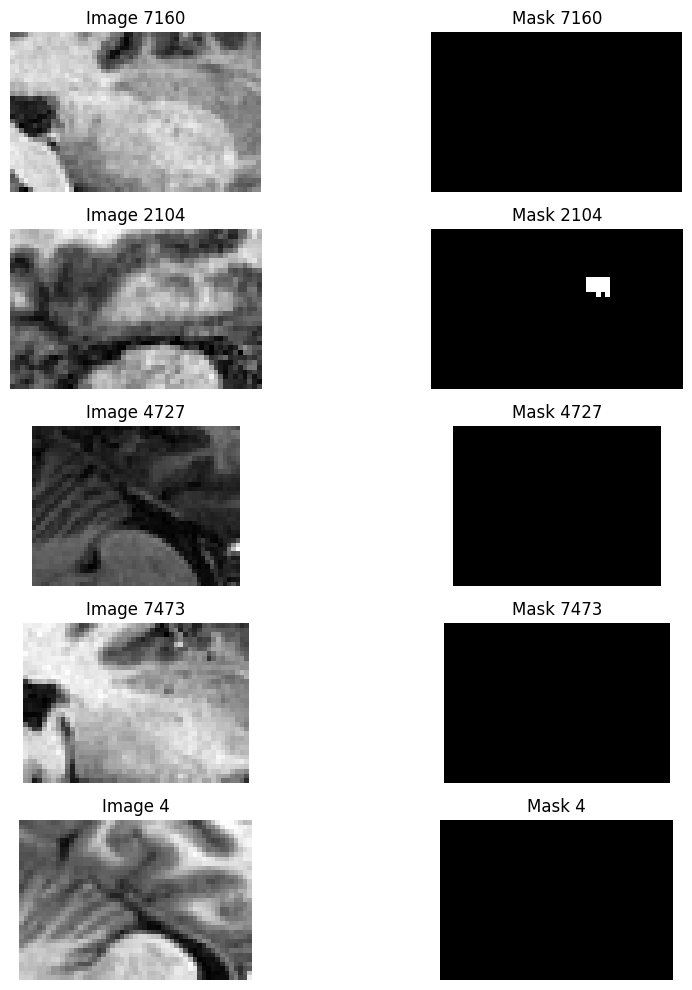

In [ ]:
import matplotlib.pyplot as plt

def visualize_images_with_masks(images, masks, num_pairs=5):
    """
    Visualize a set of images and their corresponding masks.

    Parameters:
    images (numpy.ndarray): Array of image data.
    masks (numpy.ndarray): Array of mask data.
    num_pairs (int): Number of image-mask pairs to visualize.
    """
    # Check if the number of pairs exceeds the dataset size
    num_pairs = min(num_pairs, len(images))

    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, num_pairs * 2))
    for i in range(num_pairs):
        # Randomly select a pair of image and mask
        idx = np.random.randint(0, len(images))

        # Display the image
        axes[i, 0].imshow(images[idx])
        axes[i, 0].set_title(f'Image {idx}')
        axes[i, 0].axis('off')

        # Display the corresponding mask
        axes[i, 1].imshow(masks[idx], cmap='gray')
        axes[i, 1].set_title(f'Mask {idx}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
visualize_images_with_masks(images, masks, num_pairs=5)


This function will overlay the mask on the image, typically with some level of transparency so that both the image and mask can be seen simultaneously.

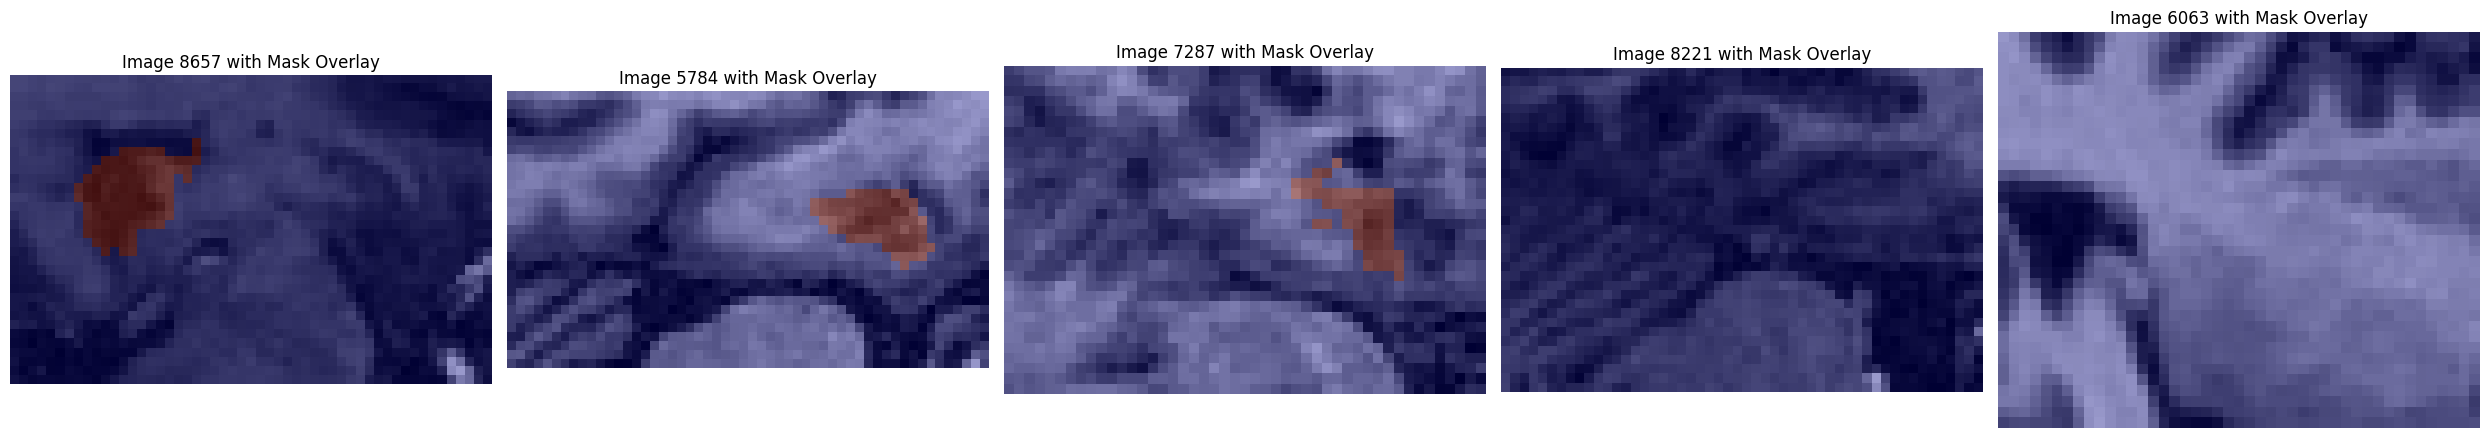

In [ ]:
import matplotlib.pyplot as plt

def visualize_images_with_mask_overlay(images, masks, num_pairs=5, alpha=0.4):
    """
    Visualize a set of images with their corresponding masks overlaid.

    Parameters:
    images (numpy.ndarray): Array of image data.
    masks (numpy.ndarray): Array of mask data.
    num_pairs (int): Number of image-mask pairs to visualize.
    alpha (float): Transparency level of the overlay.
    """
    # Check if the number of pairs exceeds the dataset size
    num_pairs = min(num_pairs, len(images))

    fig, axes = plt.subplots(1, num_pairs, figsize=(num_pairs * 5, 5))
    for i in range(num_pairs):
        # Randomly select an image and its corresponding mask
        idx = np.random.randint(0, len(images))

        # Overlay the mask on the image
        axes[i].imshow(images[idx])
        axes[i].imshow(masks[idx], cmap='jet', alpha=alpha)  # 'jet' colormap for the mask
        axes[i].set_title(f'Image {idx} with Mask Overlay')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
visualize_images_with_mask_overlay(images, masks, num_pairs=5)



#**4. Data Preprocessing**

*   **Finding the Maximum Shape in the Dataset**

This function goes through each image in the provided images array, checks its dimensions, and updates the maximum height and width found. Note that this function assumes that your images are in the HxWxC format (Height x Width x Channels).

In [ ]:
def find_max_image_size(images):
    """
    Find the maximum size of the images in the dataset.

    Parameters:
    images (numpy.ndarray): Array of image data.

    Returns:
    tuple: Maximum height and width in the dataset.
    """
    max_height, max_width = 0, 0

    for img in images:
        height, width = img.shape[:2]  # Assumes images are in HxWxC format
        max_height = max(max_height, height)
        max_width = max(max_width, width)

    return max_height, max_width

# Example usage
max_height, max_width = find_max_image_size(images)
print("Maximum size of the images:", max_height, "x", max_width)


Maximum size of the images: 43 x 59


*   **Padding to a Target Shape**

This function first checks if the image or mask is larger than the target size and resizes it if necessary. Then, it calculates the amount of padding needed and applies it equally on all sides. The padding is applied using a constant value (black color). The function works with both grayscale and color images.

In [ ]:
def pad_to_target_size(img_array, target_size=(64, 64)):
    """
    Pad or resize the image or mask to the target size.

    Parameters:
    img_array (numpy.ndarray): The original image or mask array.
    target_size (tuple): The target height and width (H, W).

    Returns:
    numpy.ndarray: The resized or padded image or mask.
    """
    # Resize if the image is larger than the target size
    height, width = img_array.shape[:2]
    if height > target_size[0] or width > target_size[1]:
        scaling_factor = min(target_size[0] / height, target_size[1] / width)
        new_size = (int(width * scaling_factor), int(height * scaling_factor))
        img_array = cv2.resize(img_array, new_size, interpolation=cv2.INTER_AREA)
        height, width = img_array.shape[:2]

    # Calculate padding amounts
    delta_w = target_size[1] - width
    delta_h = target_size[0] - height
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # Apply padding
    color = 0 if img_array.ndim == 2 else [0, 0, 0]  # Black for grayscale or RGB
    new_img = cv2.copyMakeBorder(img_array, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return new_img

# Padding images and masks
padded_images = [pad_to_target_size(img, target_size=(64, 64)) for img in images]
padded_masks = [pad_to_target_size(mask, target_size=(64, 64)) for mask in masks]


*   **Visualization**

This function will display a specified number of images from your padded images array.

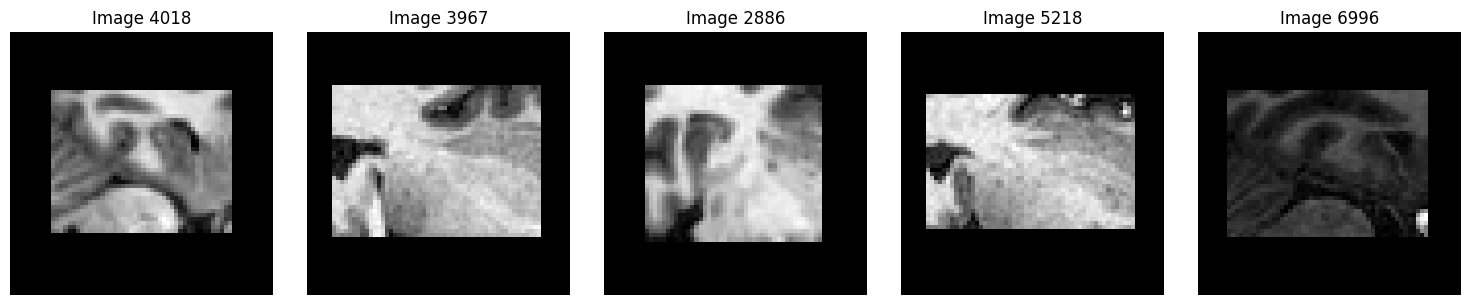

In [ ]:
def visualize_padded_images(padded_images, num_images=5):
    """
    Visualize a set of padded images.

    Parameters:
    padded_images (list): List of padded 2D image arrays.
    num_images (int): Number of images to visualize.
    """
    # Adjust the number of images to display if necessary
    num_images = min(num_images, len(padded_images))

    # Set up the matplotlib figure
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))

    for i in range(num_images):
        # Randomly select an image
        idx = np.random.randint(0, len(padded_images))
        img = padded_images[idx]

        # Check if the image is grayscale or color
        if img.ndim == 2:
            axes[i].imshow(img, cmap='gray')
        else:
            axes[i].imshow(img)

        axes[i].set_title(f'Image {idx}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
visualize_padded_images(padded_images, num_images=5)



##4.2 One-Hot Encoding for Masks

This function takes the pre-padded masks, maps the pixel values to class labels, and then converts these class labels to a one-hot encoded format. The one-hot encoded masks are now suitable for training a U-Net model for multi-class segmentation.

In [ ]:
def convert_and_one_hot_encode_masks(masks):
    """
    Convert mask pixel values to class labels and then one-hot encode for U-Net model training.

    Masks are assumed to be pre-padded to the desired target size.

    Parameters:
    masks (numpy.ndarray): Array of 2D mask arrays.

    Returns:
    numpy.ndarray: Array of one-hot encoded masks suitable for U-Net training.
    """
    one_hot_encoded_masks = []

    for mask in masks:
        # Convert mask pixel values to class labels (0: background, 1: posterior, 2: anterior)
        mask_class_labels = np.zeros_like(mask, dtype=np.int32)
        mask_class_labels[mask == 128] = 1  # Posterior
        mask_class_labels[mask == 255] = 2  # Anterior

        # Convert to one-hot encoded format
        one_hot_mask = to_categorical(mask_class_labels, num_classes=3)
        one_hot_encoded_masks.append(one_hot_mask)

    return np.array(one_hot_encoded_masks)

# Example usage
one_hot_encoded_masks = convert_and_one_hot_encode_masks(padded_masks)


In [ ]:
np.array(padded_images).shape

(9270, 64, 64, 3)

## **5. 2D U-Net Model for Segmentation**

###5.1 Encoder (Downsampling Path)

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_filters, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = Conv2D(num_filters, (3, 3), activation=None, padding='same')
        self.conv2 = Conv2D(num_filters, (3, 3), activation=None, padding='same')
        self.pool = MaxPooling2D((2, 2))
        self.dropout = Dropout(dropout)
        self.relu = Activation('relu')

    def call(self, inputs, training=False):
        x = self.relu(self.conv1(inputs))
        x = self.dropout(x, training=training)
        x = self.relu(self.conv2(x))
        p = self.pool(x)
        return x, p


###5.2 Bottleneck

In [ ]:
class Bottleneck(tf.keras.layers.Layer):
    def __init__(self, num_filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = Conv2D(num_filters, (3, 3), activation=None, padding='same')
        self.conv2 = Conv2D(num_filters, (3, 3), activation=None, padding='same')
        self.relu = Activation('relu')

    def call(self, inputs, training=False):
        x = self.relu(self.conv1(inputs))
        x = self.relu(self.conv2(x))
        return x

###5.3 Decoder (Upsampling Path)

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_filters, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.up = UpSampling2D((2, 2))
        self.concat = concatenate
        self.conv1 = Conv2D(num_filters, (3, 3), activation=None, padding='same')
        self.conv2 = Conv2D(num_filters, (3, 3), activation=None, padding='same')
        self.dropout = Dropout(dropout)
        self.relu = Activation('relu')

    def call(self, inputs, skip, training=False):
        x = self.up(inputs)
        x = self.concat([x, skip], axis=3)
        x = self.relu(self.conv1(x))
        x = self.dropout(x, training=training)
        x = self.relu(self.conv2(x))
        return x

###5.4 2D U-Net

In [ ]:
def build_2d_unet(input_shape, num_classes):
    inputs = tf.keras.Input(input_shape)

    # Encoder layers
    e1, p1 = Encoder(64)(inputs)
    e2, p2 = Encoder(128)(p1)
    e3, p3 = Encoder(256)(p2)
    e4, p4 = Encoder(512)(p3)

    # Bottleneck layer
    b = Bottleneck(1024)(p4)

    # Decoder layers
    d4 = Decoder(512)(b, e4)
    d3 = Decoder(256)(d4, e3)
    d2 = Decoder(128)(d3, e2)
    d1 = Decoder(64)(d2, e1)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(d1)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Example usage
input_shape = (64, 64, 3)  # Example input shape, adjust as needed
num_classes = 3  # Number of classes for segmentation, adjust as needed
model = build_2d_unet(input_shape, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 encoder (Encoder)           ((None, 64, 64, 64),         38720     ['input_1[0][0]']             
                              (None, 32, 32, 64))                                                 
                                                                                                  
 encoder_1 (Encoder)         ((None, 32, 32, 128),        221440    ['encoder[0][1]']             
                              (None, 16, 16, 128))                                                
                                                                                              

## **6. Model Training**

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
train_images, val_images, train_masks, val_masks = train_test_split(padded_images, one_hot_encoded_masks, test_size=0.2, random_state=42)


# Assume `train_images`, `train_masks`, `val_images`, `val_masks` are your preprocessed datasets
history = model.fit(np.array(train_images), np.array(train_masks), validation_data=(np.array(val_images), np.array(val_masks)), epochs=10)


Epoch 1/10
232/232 [==============================] - 63s 193ms/step - loss: 0.1108 - accuracy: 0.9747 - val_loss: 0.0441 - val_accuracy: 0.9837
Epoch 2/10
232/232 [==============================] - 34s 149ms/step - loss: 0.0309 - accuracy: 0.9878 - val_loss: 0.0261 - val_accuracy: 0.9902
Epoch 3/10
232/232 [==============================] - 35s 152ms/step - loss: 0.0235 - accuracy: 0.9905 - val_loss: 0.0222 - val_accuracy: 0.9914
Epoch 4/10
232/232 [==============================] - 35s 153ms/step - loss: 0.0204 - accuracy: 0.9917 - val_loss: 0.0204 - val_accuracy: 0.9917
Epoch 5/10
232/232 [==============================] - 36s 153ms/step - loss: 0.0185 - accuracy: 0.9924 - val_loss: 0.0177 - val_accuracy: 0.9930
Epoch 6/10
232/232 [==============================] - 35s 152ms/step - loss: 0.0174 - accuracy: 0.9929 - val_loss: 0.0173 - val_accuracy: 0.9929
Epoch 7/10
232/232 [==============================] - 35s 152ms/step - loss: 0.0166 - accuracy: 0.9932 - val_loss: 0.0161 - val_ac

In [ ]:
model.save('2Dunet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


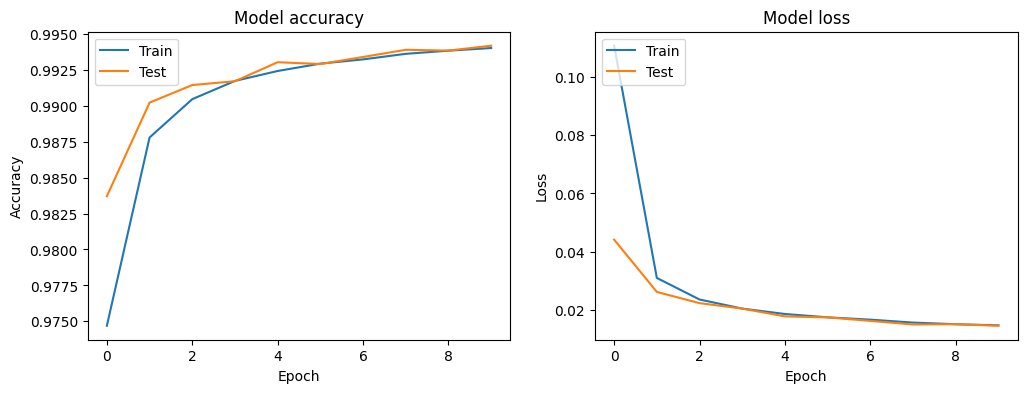

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()



## **7. 2D U-Net Model with transfer learning**

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_filters, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.up = UpSampling2D((2, 2))
        self.concat = concatenate
        self.conv1 = Conv2D(num_filters, (3, 3), activation=None, padding='same')
        self.conv2 = Conv2D(num_filters, (3, 3), activation=None, padding='same')
        self.dropout = Dropout(dropout)
        self.relu = Activation('relu')

    def call(self, inputs, skip, training=False):
        x = self.up(inputs)
        # Ensure the shapes of x and skip match
        x = tf.image.resize(x, [skip.shape[1], skip.shape[2]])
        x = self.concat([x, skip], axis=3)
        x = self.relu(self.conv1(x))
        x = self.dropout(x, training=training)
        x = self.relu(self.conv2(x))
        return x

def build_2d_unet_with_efficientnet(input_shape, num_classes):
    inputs = tf.keras.Input(input_shape)

    # Load the pre-trained EfficientNetB0 model
    efficientnet = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)

    # Skip connections from different layers of EfficientNet
    skip_connections = ['block6a_expand_activation', 'block4a_expand_activation',
                        'block3a_expand_activation', 'block2a_expand_activation']

    # Extracting the skip connections
    skips = [efficientnet.get_layer(name).output for name in skip_connections]

    # Bottleneck
    bottleneck = efficientnet.output
    bottleneck = UpSampling2D((2, 2))(bottleneck)  # Upsample bottleneck to match dimensions

    # Decoder layers
    decoder_filters = [512, 256, 128, 64]
    x = bottleneck
    for i, filters in enumerate(decoder_filters):
        if i < len(skips):
            skip = skips[-(i+1)]
        else:
            skip = None
        x = Decoder(filters)(x, skip)

    # Final upsampling and output layer
    x = UpSampling2D(size=(input_shape[0] // x.shape[1], input_shape[1] // x.shape[2]))(x)
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


# Example usage
input_shape = (64, 64, 3)
num_classes = 3
model_with_efficientnet = build_2d_unet_with_efficientnet(input_shape, num_classes)
model_with_efficientnet.summary()


16705208/16705208 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 64, 64, 3)            0         ['input_2[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 64, 64, 3)            7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)   

In [ ]:
# Compile the model
model_with_efficientnet.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


# Assume `train_images`, `train_masks`, `val_images`, `val_masks` are your preprocessed datasets
history = model_with_efficientnet.fit(np.array(train_images), np.array(train_masks), validation_data=(np.array(val_images), np.array(val_masks)), epochs=10)


Epoch 1/10
232/232 [==============================] - 124s 296ms/step - loss: 0.0893 - accuracy: 0.9755 - val_loss: 0.1182 - val_accuracy: 0.9779
Epoch 2/10
232/232 [==============================] - 53s 228ms/step - loss: 0.0632 - accuracy: 0.9771 - val_loss: 0.1226 - val_accuracy: 0.9779
Epoch 3/10
232/232 [==============================] - 51s 222ms/step - loss: 0.0606 - accuracy: 0.9773 - val_loss: 0.1282 - val_accuracy: 0.9779
Epoch 4/10
232/232 [==============================] - 53s 230ms/step - loss: 0.0594 - accuracy: 0.9775 - val_loss: 0.0830 - val_accuracy: 0.9779
Epoch 5/10
232/232 [==============================] - 53s 229ms/step - loss: 0.0582 - accuracy: 0.9776 - val_loss: 0.1629 - val_accuracy: 0.9779
Epoch 6/10
232/232 [==============================] - 53s 229ms/step - loss: 0.0577 - accuracy: 0.9776 - val_loss: 0.0662 - val_accuracy: 0.9780
Epoch 7/10
232/232 [==============================] - 53s 229ms/step - loss: 0.0570 - accuracy: 0.9777 - val_loss: 0.1766 - val_a

In [ ]:
model.save('2Dunet_model_with_efficientnet.h5')

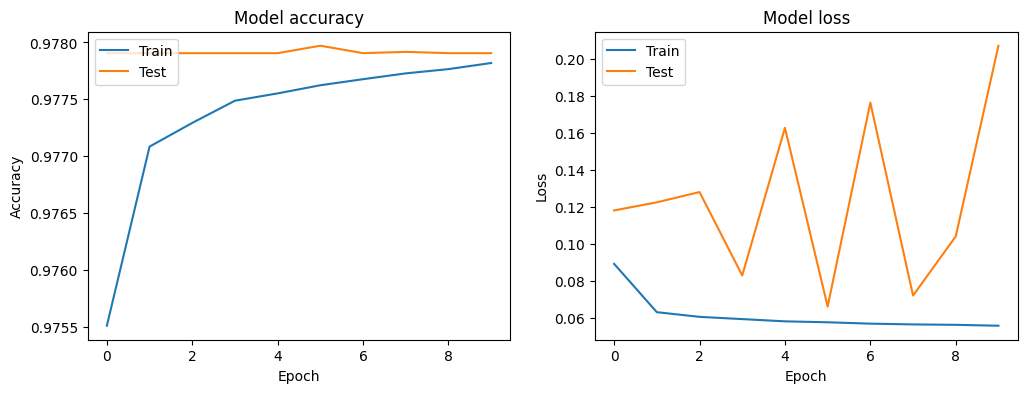

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()



##**8. Prediction**


1/1 [==============================] - 1s 1s/step


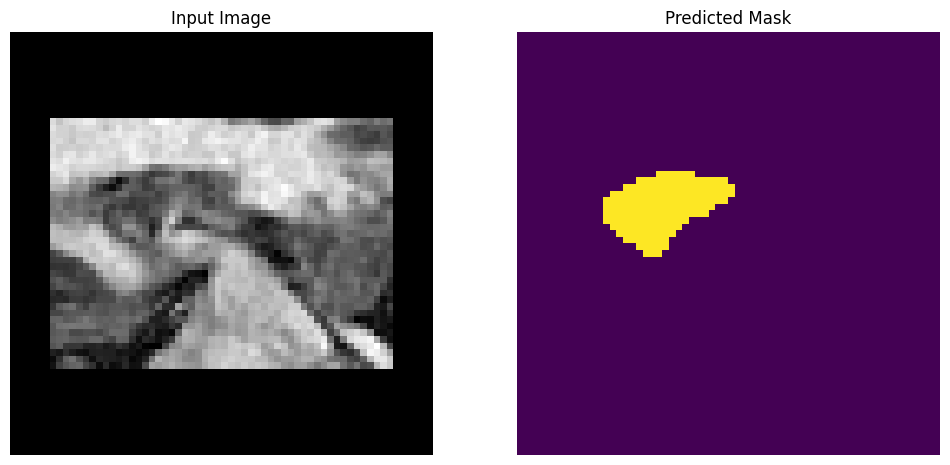

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Load a trained model (replace 'path_to_saved_model' with your model's file path)
# model = tf.keras.models.load_model('/content/2Dunet_model.h5')

# Load and preprocess an input image
image_path = '/content/drive/MyDrive/Hippocampus/Hippocampus_png/hippocampus_024.nii/slice_017.png'  # Replace with your image path
input_image = load_img(image_path)
input_image = img_to_array(input_image) / 255.0  # Normalize pixel values
input_image = pad_to_target_size(input_image, target_size=(64, 64))
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

# Make a prediction
predicted_mask = model.predict(input_image)

# Process the output (if necessary) and visualize
predicted_mask = np.argmax(predicted_mask, axis=-1)  # Convert probabilities to class labels
predicted_mask = predicted_mask[0]  # Remove batch dimension

# Visualize the input image and the predicted mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(input_image))
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask)
plt.title('Predicted Mask')
plt.axis('off')

plt.show()


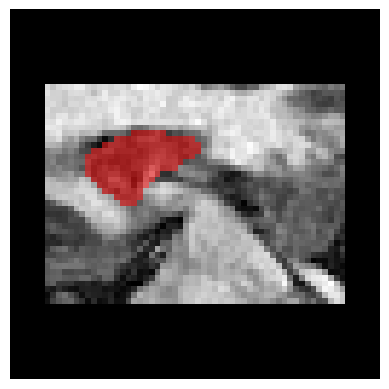

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def overlay_mask_on_image(image, mask, mask_alpha=0.5):
    """
    Overlays a mask onto an image using matplotlib.

    Parameters:
    - image: The original image (numpy array).
    - mask: The mask to overlay (numpy array).
    - mask_alpha: Transparency of the mask overlay (float between 0 and 1).

    The function displays the overlaid image.
    """

    # Ensure mask is a boolean array
    mask = mask.astype(bool)

    # Create an RGBA version of the greyscale mask
    colored_mask = np.zeros((*mask.shape, 4))  # 4 channels: R, G, B, Alpha
    colored_mask[..., 0] = 1.0  # Red channel
    colored_mask[..., 3] = mask * mask_alpha  # Alpha channel

    # Show original image
    plt.imshow(image)

    # Overlay mask
    plt.imshow(colored_mask, interpolation='none')

    plt.axis('off')
    plt.show()

# Example usage:
# Assuming `input_image` is your original image and `predicted_mask` is the output from your model
overlay_mask_on_image(input_image[0], predicted_mask)
